# gillAl

*gillAl* function is based on the Gillespie's algorithm to compute stochastically the output of biological system. As this function calculates the output numerically, it does not need to use any solver or package. It computes the amount of concentration for each species in a random time instant. Likewise, the reaction to be calculated it is random; what means that in each time instant takes places a different reaction.

In [36]:
#requiered packages
import numpy as np
import simsysbio as s2b
import matplotlib.pyplot as plt

**Creates System Input**

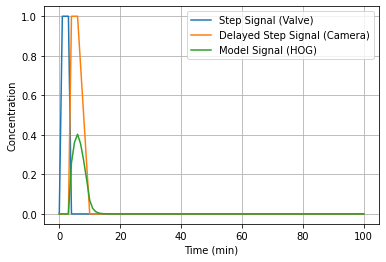

In [37]:
#computes a hog signal as system input
#duration experiment
tend = np.array([100], float)

#pulse start and end 
ton = np.array([1], float)
tdur = np.array([3], float)

#calculo de la expresion y sus respectivos perfiles
inputHOG, tog, perfiles = s2b.HOGexpr(ton, tdur, tend)

#Plotting
plt.figure()
plt.plot(tog, perfiles['t_u_Valve'], label='Step Signal (Valve)')
plt.plot(perfiles['t_u_Chamber'][0], perfiles['t_u_Chamber'][1], label='Delayed Step Signal (Camera)')
plt.plot(tog, inputHOG, label='Model Signal (HOG)')
plt.legend(loc='best')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()
plt.show()

**Defines System Properties**

In [38]:
#number of cell
ncells = 1

#kinetic parameters
parsValues = [4.0, 0.010, 1.0, 0.006]

#initial concentratios of the species
A0 = np.zeros((2,1))

#reagent and product matrices
reactants = np.array([[0, 1, 1, 0],[0, 0, 0, 1]])
products = np.array([[1, 0, 1, 0],[0, 0, 1, 0]])

#reaction affected by the input stimulus (0 = first reaction)
indexU = 0

Adds fake species to the matrices. This species is meant to keep increasing in each iteration.

In [39]:
#Adds fake species and reaction
cfake = np.zeros((reactants.shape[0],1))

reactants = np.hstack((reactants, cfake))
products = np.hstack((products, cfake))

rfake = np.zeros((1,reactants.shape[1]))

reactants = np.vstack((reactants, rfake))
products = np.vstack((products, rfake))
products[-1,-1] = 2.0

reactants = reactants.astype(int)
products = products.astype(int)

print("Reagent Matrix:", reactants)
print("Products Matrix:", products)

Reagent Matrix: [[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]
Products Matrix: [[1 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 2]]


**Processing of the whole cell population**

In [40]:
#array to store system output
valuesStoch = np.zeros((len(A0), len(tog),ncells))

#loop for computing every cell in the system
for cell in range(0,ncells):
    
    #copy parameters to an alternative variable that will change through each 
    #iteration
    knu = np.copy(parsValues)
    #appends the additional kinetic parameter for the fake reaction
    knu = np.append(parsValues, 1)
    #species initial concentration of each cell
    A0 = np.zeros((2,1))
    #appends initial condion of fake species
    A0 = np.append(A0, 0)
    
    #####################################################################
    #these set of parameters will take into account the effect from the input
    real_knu = np.copy(knu)
    
    #number of species
    Nchs = A0.shape[0]
    #number of parameters
    q = knu.shape[0]
    
    #initial conditions
    m = 0
    A = np.zeros((len(A0), 1))
    A[:,0] = A0
    t = np.zeros(1)
    
    while t[m] <= tog[-1]:
        #creates a temporal variable to store the propensity values gotten from 
        #reactions and species
        alpha = np.zeros(q)
        
        #STEP 1
        #for each parameter it is computed the propensity for each respective 
        #reaction
        
        #it is calculated av=hv*cv. where cv is reaction kinetic parameter.
        #hv is the number of different molecular reagent in a reaction Ru
        for i in range(0,q):
            if i == indexU:
                approx_t = np.floor(t[m]).astype(int)# + 1
                real_knu[i] = knu[i]*inputHOG[approx_t]
            #end if i
        
            alpha[i] = real_knu[i]
    
            for j in range(0,Nchs):
                for s in range(0,reactants[j,i]):
                    ss = 1
                    alpha[i] = alpha[i]*(A[j,m]-ss+1)
                #end for s
            #end for j
            
        #end for i

        #calculation of a0 = sum(av)          
        alpha0 = np.sum(alpha)
        
        #STEP 2
        #generates two random numbers. first one r1 is used to compute tau's 
        #value. tau = (1/a0)*ln(1/r1). tau represents the instant of time in 
        #which next reaction takes place
        r = np.random.rand(2)

        alpha0_1 = 1/alpha0
        tau = alpha0_1*(np.log(1/r[0]))
        
        #r2 is used to determine the type of reaction to take place in a certain
        #instant of time. To find it out the next condition have to be true
        #--> sum(avi/ao) > r2   
        ii = 0
        sumalpha = alpha0_1*alpha[0]
    
        while r[1] >= sumalpha:
            ii += 1
            sumalpha += alpha0_1*alpha[ii]
        #end while r
        
        #STEP 3
        #appends computed time and concentration values 
        #increases m value
        Atemp = A[:,m] - reactants[:,ii] + products[:,ii] 
        A = np.concatenate((A, np.array([Atemp]).T), axis=1)
        t = np.append(t, (t[m] + tau))
        
        #updates m
        m += 1
        #while loop repeats until time vector values overcome duration 
        #experiment
    #end while t
    
    #set last element of the time vector as the same as duration experiment   
    if t[-1] > tog[-1]:
        t[-1] = tog[-1]
    
    #deletes values smaller than 0 and remove fake species
    A[A < 0] = 0
    Apost = np.copy(A[:-1,:])
    
    #creates an array to store concentration values. The array is 
    #overdimentionated to repeat some values
    Npl = 2*(len(t) - 2) + 2
    Apl = np.zeros((Nchs - 1, Npl))
    
    #appends some reapeated values to perform interpolation
    for i in range(0,len(t) - 1):#-1
        Apl[:,2*i] = Apost[:,i]
        Apl[:,2*i+1] = Apost[:,i]
    #end for i
    
    #creates a new array to store time. Assigns initial and end values from 
    #experiment time vector
    tpl = np.zeros(Npl) 
    tpl[0] = t[0]
    tpl[Npl-1] = t[len(t) - 1]
    
    #repeats some  adjacent values to perform interpolation
    for j in range(1,len(t) - 1):
        tpl[2*j-1] = t[j]
        tpl[2*j] = t[j] 
    #end for j
    
    #deletes repeated values and takes original indexes from remaining values
    tpl2, ind = np.unique(tpl, return_index=True)
    Apl2 = Apl[:,ind]
    
    #performs interporlation over data to adjust it to real time vector
    Apl2x = np.zeros((len(tog),Nchs - 1))

    for inter in range(0,Nchs - 1):
        Apl2x[:,inter] = np.interp(tog, tpl2, Apl2[inter,:].T)
    #end for inter
    
    #deletes values smaller than o
    Apl2x[Apl2x<0] = 0
    Apl2x = Apl2x.T
    
    #final array which it contains system output
    valuesStoch[:,:,cell] = Apl2x[:,:]
    print("Cell:", cell+1)
#end for cell

Cell: 1


**Plotting**

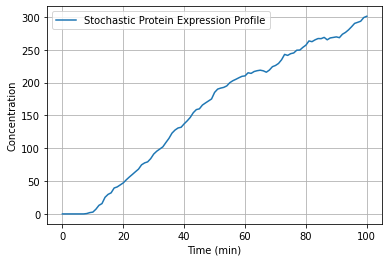

In [41]:
#graficación de la respuesta del sistema    
plt.figure()
for fig in range(0,1):
    plt.plot(tog,valuesStoch[1,:,fig],label='Stochastic Protein Expression Profile')
    plt.legend(loc='best')
    plt.xlabel('Time (min)')
    plt.ylabel('Concentration')
    plt.grid()
    plt.legend(loc='best')
plt.show()